In [2]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import evaluate  # Thay vì: from datasets import load_metric
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os


In [5]:
import html  

def prepare_and_split_data(en_file, vi_file, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    with open(en_file, 'r', encoding='utf-8') as f_en, open(vi_file, 'r', encoding='utf-8') as f_vi:
        en_lines = f_en.readlines()
        vi_lines = f_vi.readlines()
    
    assert len(en_lines) == len(vi_lines), "Số dòng không khớp!"
    
  
    data = [
        f"[EN] {html.unescape(en.strip())} [VI] {html.unescape(vi.strip())}"
        for en, vi in zip(en_lines, vi_lines)
    ]
    
    train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=42)
    val_data, test_data = train_test_split(temp_data, train_size=val_ratio/(val_ratio + test_ratio), random_state=42)
    
    return train_data, val_data, test_data


In [6]:
en_path = "/kaggle/input/data-nlp/train.en.txt"
vi_path = "/kaggle/input/data-nlp/train.vi.txt"


In [7]:
# Tách dữ liệu
train_data, val_data, test_data = prepare_and_split_data(en_path, vi_path)
print(len(train_data))
print(len(val_data))
print(len(test_data))

106653
13332
13332


In [8]:
# 2. Tokenizer
# Sử dụng tokenizer pretrained của GPT-2
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Gán pad_token = eos_token hoặc thêm [PAD]
tokenizer.pad_token = tokenizer.eos_token  # hoặc dùng cách 2


# Thêm token đặc biệt
tokenizer.add_special_tokens({'additional_special_tokens': ['[EN]', '[VI]']})

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

2

In [9]:

# Lưu tokenizer
tokenizer.save_pretrained('custom_tokenizer')

('custom_tokenizer/tokenizer_config.json',
 'custom_tokenizer/special_tokens_map.json',
 'custom_tokenizer/vocab.json',
 'custom_tokenizer/merges.txt',
 'custom_tokenizer/added_tokens.json')

In [10]:
# Mã hóa dữ liệu
def encode_data(data):
    return tokenizer(data, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

In [11]:
train_encodings = encode_data(train_data)
val_encodings = encode_data(val_data)
test_encodings = encode_data(test_data)

In [12]:
# 3. Dataset tùy chỉnh
class TranslationDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = item['input_ids'].clone()  # GPT-2 sử dụng input_ids làm nhãn
        return item

In [13]:
train_dataset = TranslationDataset(train_encodings)
val_dataset = TranslationDataset(val_encodings)
test_dataset = TranslationDataset(test_encodings)

In [14]:
# 4. Thiết lập mô hình và huấn luyện
# Tải mô hình GPT-2
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))  # Điều chỉnh embedding cho tokenizer mới

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50259, 768)

In [15]:
# Thiết lập thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [26]:
# Thiết lập tham số huấn luyện
num_epochs = 15
batch_size = 8
learning_rate = 2e-5

In [27]:
# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Khởi tạo optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

In [29]:
# Hàm đánh giá trên tập validation/test
def evaluate_model_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss


In [30]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

scaler = GradScaler()
best_val_loss = float('inf')
patience = 3  # Số epoch không cải thiện được phép
patience_counter = 0
val_losses = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        optimizer.zero_grad()

        # Mixed Precision Forward pass
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        # Backward pass with gradient scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    # Tính loss trung bình
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    avg_val_loss = evaluate_model_loss(model, val_loader)
    scheduler.step(avg_val_loss)

    val_losses.append(avg_val_loss)
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Kiểm tra điều kiện lưu mô hình tốt nhất
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        model.save_pretrained('fine_tuned_gpt2_best')
        tokenizer.save_pretrained('fine_tuned_gpt2_best')
        print("Đã lưu mô hình tốt nhất!")
    else:
        patience_counter += 1
        print(f"Không cải thiện — Đếm dừng sớm: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Dừng sớm: Không còn cải thiện sau nhiều epoch.")
            break

# Lưu mô hình cuối cùng (nếu cần)
model.save_pretrained('fine_tuned_gpt2_final')
tokenizer.save_pretrained('fine_tuned_gpt2_final')
print("Đã lưu mô hình cuối cùng.")


/tmp/ipykernel_31/2658973989.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/15:   0%|          | 0/13332 [00:00<?, ?it/s]/tmp/ipykernel_31/2658973989.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/15: 100%|██████████| 13332/13332 [34:20<00:00,  6.47it/s]



Epoch 1/15
Train Loss: 1.3344
Validation Loss: 1.1387
Đã lưu mô hình tốt nhất!


Epoch 2/15:   0%|          | 0/13332 [00:00<?, ?it/s]/tmp/ipykernel_31/2658973989.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/15: 100%|██████████| 13332/13332 [34:21<00:00,  6.47it/s]



Epoch 2/15
Train Loss: 1.1172
Validation Loss: 1.0407
Đã lưu mô hình tốt nhất!


Epoch 3/15:   0%|          | 0/13332 [00:00<?, ?it/s]/tmp/ipykernel_31/2658973989.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/15: 100%|██████████| 13332/13332 [34:22<00:00,  6.46it/s]



Epoch 3/15
Train Loss: 1.0304
Validation Loss: 0.9949
Đã lưu mô hình tốt nhất!


Epoch 4/15:   0%|          | 0/13332 [00:00<?, ?it/s]/tmp/ipykernel_31/2658973989.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/15: 100%|██████████| 13332/13332 [34:22<00:00,  6.46it/s]



Epoch 4/15
Train Loss: 0.9766
Validation Loss: 0.9663
Đã lưu mô hình tốt nhất!


Epoch 5/15:   0%|          | 0/13332 [00:00<?, ?it/s]/tmp/ipykernel_31/2658973989.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/15: 100%|██████████| 13332/13332 [34:21<00:00,  6.47it/s]



Epoch 5/15
Train Loss: 0.9376
Validation Loss: 0.9502
Đã lưu mô hình tốt nhất!


Epoch 6/15:   0%|          | 0/13332 [00:00<?, ?it/s]/tmp/ipykernel_31/2658973989.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/15: 100%|██████████| 13332/13332 [34:22<00:00,  6.46it/s]



Epoch 6/15
Train Loss: 0.9063
Validation Loss: 0.9381
Đã lưu mô hình tốt nhất!


Epoch 7/15:   0%|          | 0/13332 [00:00<?, ?it/s]/tmp/ipykernel_31/2658973989.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/15: 100%|██████████| 13332/13332 [34:21<00:00,  6.47it/s]



Epoch 7/15
Train Loss: 0.8797
Validation Loss: 0.9316
Đã lưu mô hình tốt nhất!


Epoch 8/15:   0%|          | 0/13332 [00:00<?, ?it/s]/tmp/ipykernel_31/2658973989.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/15: 100%|██████████| 13332/13332 [34:21<00:00,  6.47it/s]



Epoch 8/15
Train Loss: 0.8565
Validation Loss: 0.9259
Đã lưu mô hình tốt nhất!


Epoch 9/15:   0%|          | 0/13332 [00:00<?, ?it/s]/tmp/ipykernel_31/2658973989.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/15: 100%|██████████| 13332/13332 [34:21<00:00,  6.47it/s]



Epoch 9/15
Train Loss: 0.8359
Validation Loss: 0.9245
Đã lưu mô hình tốt nhất!


Epoch 10/15:   0%|          | 0/13332 [00:00<?, ?it/s]/tmp/ipykernel_31/2658973989.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/15: 100%|██████████| 13332/13332 [34:20<00:00,  6.47it/s]



Epoch 10/15
Train Loss: 0.8168
Validation Loss: 0.9231
Đã lưu mô hình tốt nhất!


Epoch 11/15:   0%|          | 0/13332 [00:00<?, ?it/s]/tmp/ipykernel_31/2658973989.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/15: 100%|██████████| 13332/13332 [34:21<00:00,  6.47it/s]



Epoch 11/15
Train Loss: 0.7990
Validation Loss: 0.9243
Không cải thiện — Đếm dừng sớm: 1/3


Epoch 12/15: 100%|██████████| 13332/13332 [34:21<00:00,  6.47it/s]



Epoch 12/15
Train Loss: 0.7825
Validation Loss: 0.9253
Không cải thiện — Đếm dừng sớm: 2/3


Epoch 13/15: 100%|██████████| 13332/13332 [34:23<00:00,  6.46it/s]



Epoch 13/15
Train Loss: 0.7564
Validation Loss: 0.9283
Không cải thiện — Đếm dừng sớm: 3/3
Dừng sớm: Không còn cải thiện sau nhiều epoch.
Đã lưu mô hình cuối cùng.


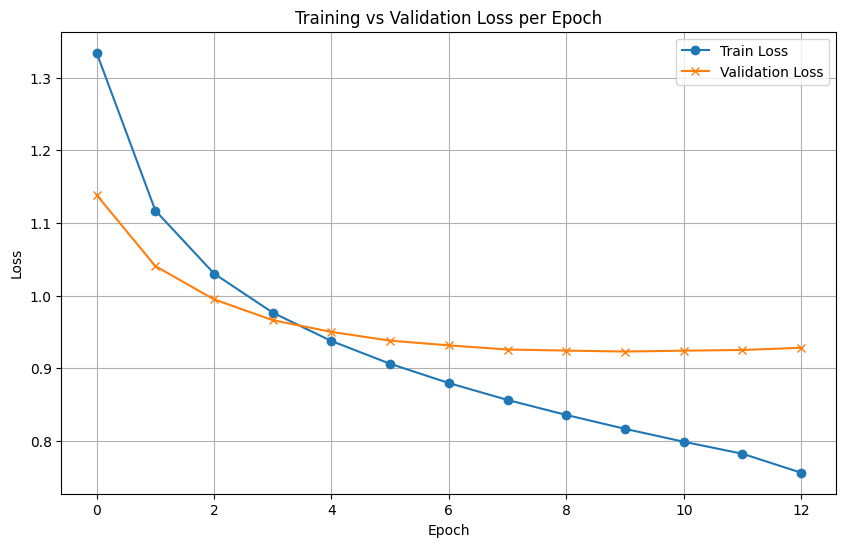

In [31]:
#chạy lại ko đc đụng-_-

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title("Training vs Validation Loss per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')

In [ ]:
# Lưu mô hình cuối cùng
model.save_pretrained('fine_tuned_gpt2_final')
tokenizer.save_pretrained('fine_tuned_gpt2_final')


In [16]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Nạp lại tokenizer và model từ thư mục đã lưu
tokenizer = GPT2Tokenizer.from_pretrained('fine_tuned_gpt2_final')
model = GPT2LMHeadModel.from_pretrained('fine_tuned_gpt2_final')

# Đưa model sang GPU nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.eval()  # Đặt model ở chế độ đánh giá


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

In [17]:
!pip install rouge_score sacrebleu


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=6b1d2bd20473534da3532632699eaacb19251b5bcc6d7cc9f3ad20c6ad99d7ea
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [18]:
# 5. Đánh giá bằng ROUGE và BLEU
rouge = evaluate.load('rouge')
bleu = evaluate.load('sacrebleu')

In [29]:
from tqdm import tqdm

def evaluate_model_metrics(model, tokenizer, test_data):
    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for item in tqdm(test_data, desc="Evaluating"):
            input_text = item.split('[VI]')[0] + '[VI]'
            ref = item.split('[VI]')[-1].strip()

            inputs = tokenizer(
                input_text,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=128
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model.generate(
                **inputs,
                max_new_tokens=128,
                num_beams=5,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id
            )

            decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
            if '[VI]' in decoded:
                pred = decoded.split('[VI]')[-1].strip()
            else:
                pred = decoded.strip()

            predictions.append(pred)
            references.append([ref])

    rouge_result = rouge.compute(predictions=predictions, references=[r[0] for r in references])
    bleu_result = bleu.compute(predictions=predictions, references=references)

    return rouge_result, bleu_result


In [30]:
# Đánh giá trên 200 mẫu test
rouge_result, bleu_result = evaluate_model_metrics(model, tokenizer, test_data[:200])

print("ROUGE:", rouge_result)
print(f"BLEU: {bleu_result['score']:.2f}")

print("Huấn luyện và đánh giá hoàn tất!")


Evaluating: 100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


ROUGE: {'rouge1': 0.5512845688534014, 'rouge2': 0.3582616349003612, 'rougeL': 0.47596252213705403, 'rougeLsum': 0.47569609256638523}
BLEU: 13.40
Huấn luyện và đánh giá hoàn tất!


In [32]:
# Đánh giá trên 2000 mẫu test
rouge_result, bleu_result = evaluate_model_metrics(model, tokenizer, test_data[:2000])

print("ROUGE:", rouge_result)
print(f"BLEU: {bleu_result['score']:.2f}")

print("Huấn luyện và đánh giá hoàn tất!")


Evaluating: 100%|██████████| 2000/2000 [29:03<00:00,  1.15it/s]


ROUGE: {'rouge1': 0.5495228424624159, 'rouge2': 0.3601512892805063, 'rougeL': 0.4766466256183437, 'rougeLsum': 0.47700195695932873}
BLEU: 14.53
Huấn luyện và đánh giá hoàn tất!


In [23]:
def translate(model, tokenizer, input_text=None, test_data=None, num_examples=5):
    model.eval()
    translations = []

    def clean_translation(decoded_text, input_en_part):
        # Loại bỏ phần đầu tiếng Anh hoặc [VI] nếu có
        if '[VI]' in decoded_text:
            return decoded_text.split('[VI]')[-1].strip()
        elif input_en_part in decoded_text:
            return decoded_text.replace(input_en_part, '').strip()
        else:
            return decoded_text.strip()

    if input_text:
        input_text_clean = input_text.strip()
        input_text_full = f"[EN] {input_text_clean} [VI]"
        inputs = tokenizer(input_text_full, return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            num_beams=5,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id
        )

        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        translation = clean_translation(decoded, input_text_clean)

        translations.append({
            "input": input_text_clean,
            "translation": translation,
            "reference": None
        })

    if test_data:
        for item in test_data[:num_examples]:
            en_part = item.split('[VI]')[0].replace('[EN]', '').strip()
            input_text = f"[EN] {en_part} [VI]"
            reference = item.split('[VI]')[-1].strip()

            inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model.generate(
                **inputs,
                max_new_tokens=256,
                num_beams=5,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id
            )

            decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
            translation = clean_translation(decoded, en_part)

            translations.append({
                "input": en_part,
                "translation": translation,
                "reference": reference
            })

    # In kết quả
    for i, t in enumerate(translations):
        print(f"\nExample {i + 1}:")
        print(f"Input (EN): {t['input']}")
        print(f"Translation (VI): {t['translation']}")
        if t['reference']:
            print(f"Reference (VI): {t['reference']}")

    return translations


In [ ]:
# Thử dịch trên tập test (5 ví dụ đầu tiên)
print("\nDịch thử trên tập test:")
results = translate(model, tokenizer, test_data=test_data, num_examples=5)


Dịch thử trên tập test:

Example 1:
Input (EN): And I would ask him every once in a while , " Dad , do you want it to sound like the record ? "
Translation (VI): Và tôi thường hỏi ông ấy mỗi lần , " Bố , ông có muốn nó nghe giống như bản ghi chép không ? "
Reference (VI): Đôi khi , tôi hỏi ông rằng : " Bố ơi , bố có muốn chơi giống như bản gốc không ạ ? "

Example 2:
Input (EN): So , we 're only going to look at the stars inside that small square , although we 've looked at all of them .
Translation (VI): Chúng ta sẽ chỉ nhìn vào những ngôi sao bên trong một hình vuông nhỏ , mặc dù chúng ta đã nhìn vào tất cả chúng .
Reference (VI): Vậy , chúng ta sẽ chỉ nhìn vào những ngôi sao bên trong hình vuông nhỏ đó , mặt dù chúng ta đã nhìn tất cả chúng .

Example 3:
Input (EN): And they travel out into the cosmos at the speed of light .
Translation (VI): Và chúng đi ra ngoài vũ trụ với tốc độ ánh sáng .
Reference (VI): Và chúng đi vào vũ trụ với vận tốc ánh sáng .

Example 4:
Input (EN): Whate